In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils

In [3]:
from pathlib import Path
current_working_directory = Path.cwd()

## Instructions
Set the global variable called SERVER to 'NUC' to obtain the data analysis for the NUC  or to 'server' for the data analysis of the server

In [4]:
METRIC = 'PROCESS_MEMORY'
SERVER = 'nuc'
UNIT = 1000000

In [5]:
DATAPATH = f"{current_working_directory}/../data/{SERVER}_data.csv"

In [6]:
data = pd.read_csv(DATAPATH)
utils.clean_and_format_df(data)
data = data.dropna(subset=[METRIC])

In [7]:
data[METRIC] = data[METRIC] / UNIT

In [8]:
subjects = list(set(data['subject'].values))
targets = ['mandelbrot', 'fannkuch_redux', 'binary_trees', 'n_body', 'spectralnorm', 'k_nucleotide', 'fasta']

GROUPS = list(
    product(subjects, targets)
)

In [9]:
data['subject'] = pd.Categorical(
    data['subject'],
    ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
)

## Descriptive Statistics

### Descriptive Statistics per Benchmark

In [10]:
def reform(dictionary):
    return {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}

In [11]:
descriptive = []

for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)

    desc = df[METRIC].describe().to_dict()
    cv = lambda x: x['std'] / x['mean']
    desc['cv'] = cv(desc)
    stats =  {'subject': subject, 'target' : target} | desc
    descriptive.append(
        stats
    )

table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')

latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

### Aggregated Descriptive Statistics

In [12]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]
    desc = df[METRIC].describe().to_dict()
    cv = lambda x: x['std'] / x['mean']
    desc['cv'] = cv(desc)
    stats =  {'subject': subject} | desc
    descriptive.append(stats)

table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,count,mean,std,min,25%,50%,75%,max,cv
8,codon,105.0,2.933516,1.704070,0.0,1.835008,3.932160,4.063232,4.980736,0.580897
5,cpython,105.0,2.858618,2.119568,0.0,0.131072,4.587520,4.718592,4.980736,0.741466
6,cython,105.0,2.460409,2.229651,0.0,0.000000,1.966080,4.718592,5.373952,0.906212
1,mypyc,105.0,3.060843,2.207966,0.0,0.000000,4.718592,4.849664,5.111808,0.721359
7,nuitka,105.0,1.512945,1.100090,0.0,0.000000,2.359296,2.359296,2.752512,0.727118
4,numba,105.0,2.755009,2.279599,0.0,0.000000,4.587520,4.849664,5.636096,0.827438
0,py3.13-jit,105.0,3.316746,2.520704,0.0,0.131072,4.980736,5.636096,6.422528,0.759993
2,pypy,105.0,2.708821,2.022135,0.0,0.131072,3.538944,4.063232,11.534336,0.746500
3,pyston-lite,105.0,2.998428,2.110163,0.0,0.000000,4.587520,4.849664,5.898240,0.703757


latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

## BarPlots

In [13]:
colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

darker_colors = [
    "#BA3636",  # Enhanced Darker Coral Red
    "#30928C",  # Enhanced Darker T`burquoise
    "#DC6E45",  # Enhanced Darker Light Salmon
    "#462865",  # Enhanced Darker Purple
    "#BEA200",  # Enhanced Darker Gold
    "#2E859C",  # Enhanced Darker Sky Blue
    "#6BA393",  # Enhanced Darker Mint
    "#C13E8A",  # Enhanced Darker Hot Pink
    "#5F300D"   # Enhanced Darker Saddle Brown
]

In [14]:
from scipy import stats

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    return df[abs(z_scores) < threshold]

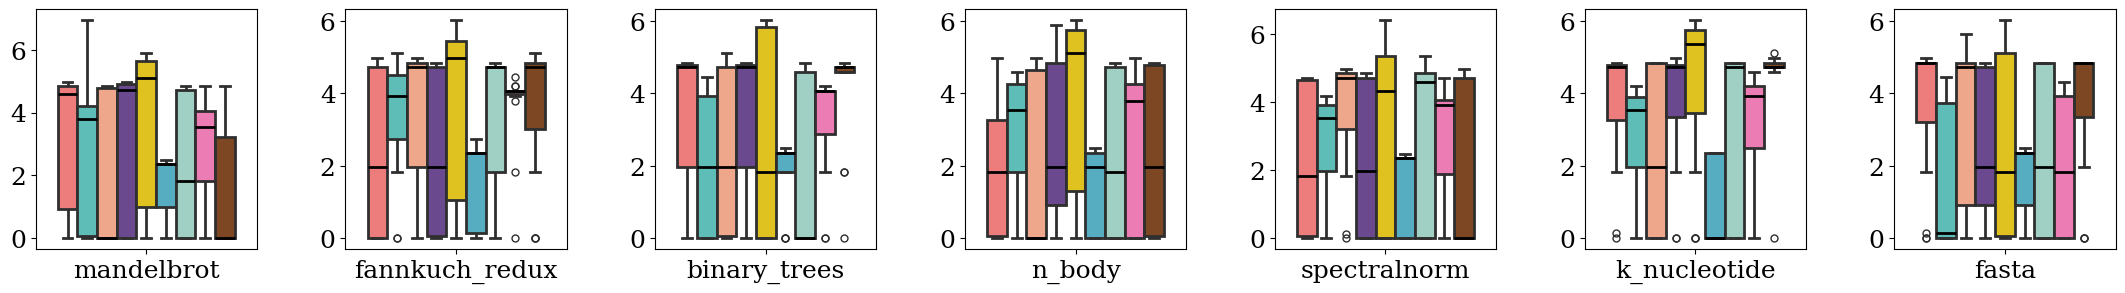

In [15]:
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df = remove_outliers_zscore(df, METRIC)
    df.sort_values(by=['subject'])

    sns.boxplot(
        x="target", y=METRIC, hue="subject", data=df, ax=axs_flat[i], palette = colors, legend = False,
        dodge=True,
        boxprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=2),
        capprops=dict(linewidth=2),
        medianprops=dict(linewidth=2, color='black'),
        flierprops=dict(marker='o', markersize=5)
    )
    
    #axs_flat[i].get_legend().remove()
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')
    axs_flat[i].tick_params(axis='x', labelsize=18)
    
        
plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"{SERVER}_{METRIC}.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Normality

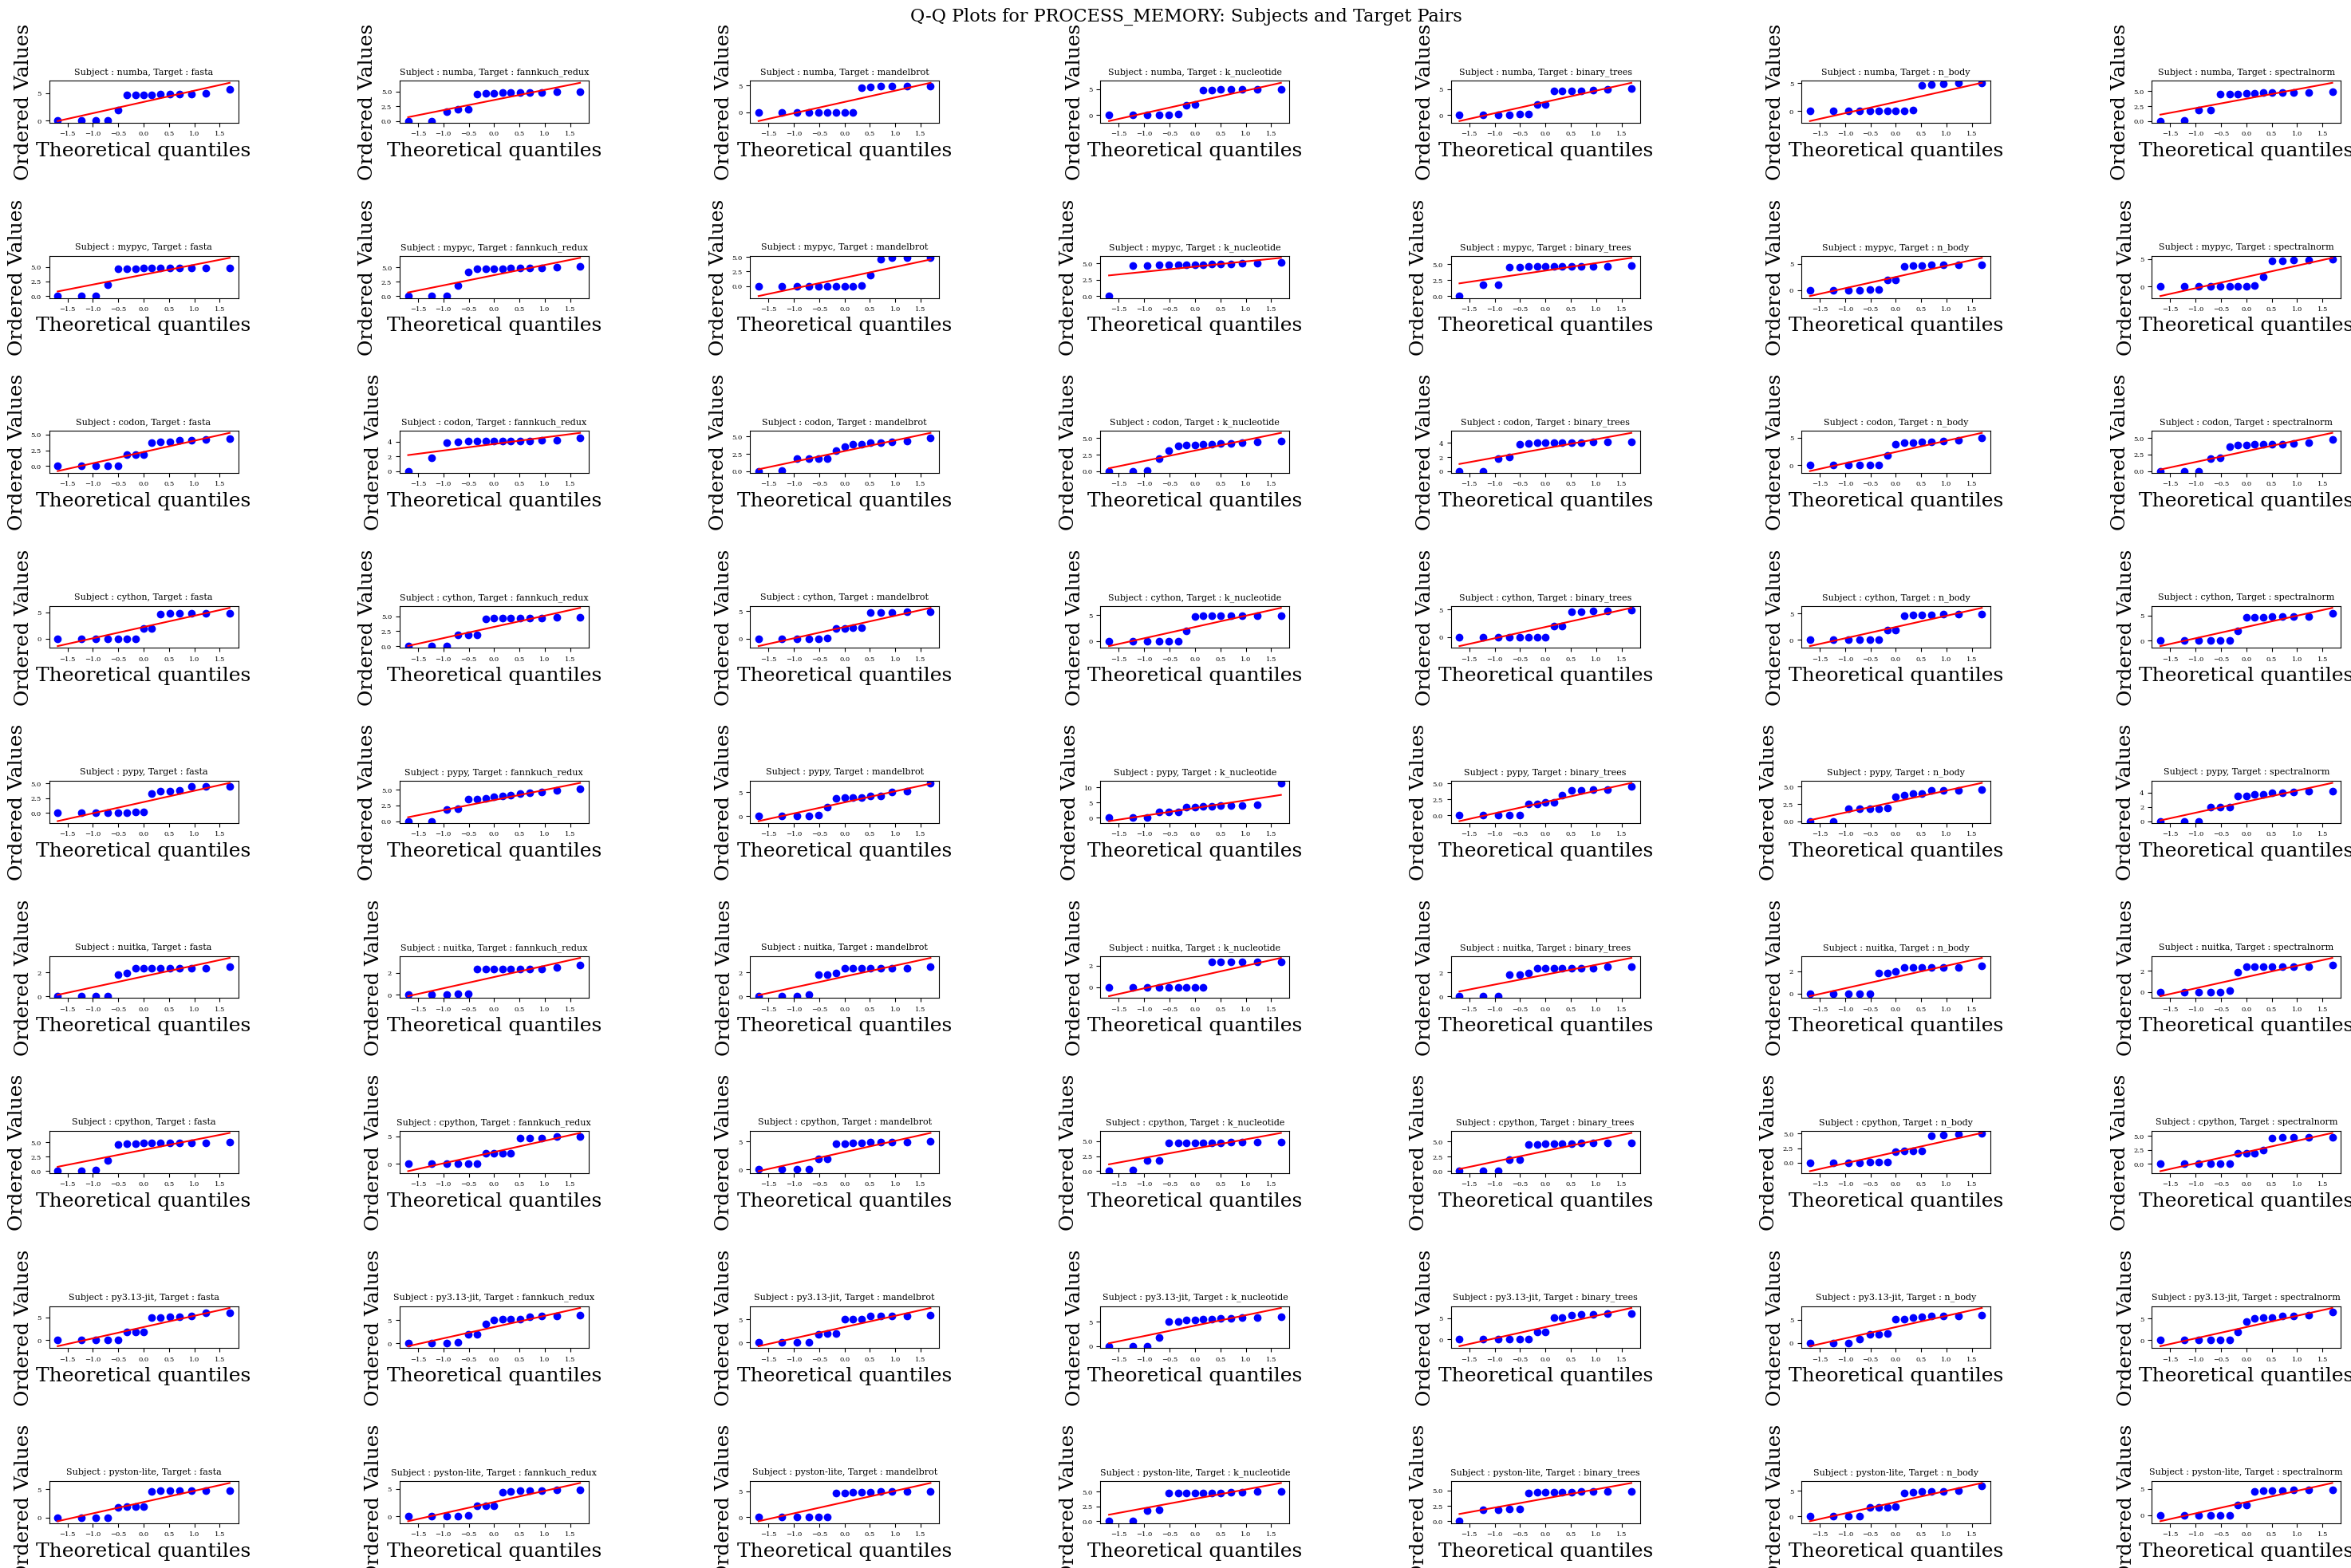

In [16]:
utils.plot_qq_grid(data, METRIC)

In [17]:
### Shapiro-Wilk Aggregated 

In [18]:
from scipy import stats

In [19]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject][METRIC]
    statistic, p_value = stats.shapiro(df)
    print(subject, p_value)

py3.13-jit 3.664898889037724e-11
mypyc 1.2784232292176156e-13
pypy 6.326389642561624e-09
pyston-lite 6.0022394716024394e-12
numba 7.304054957165608e-13
cpython 4.356895966442253e-12
cython 1.974168614181996e-12
nuitka 9.772458150037808e-14
codon 6.485387627407742e-12


### Shapiro-Wilk per Benchmark

In [20]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)[METRIC]
    statistic, p_value = stats.shapiro(df)
    row = {'subject': subject, 'target' : target, 'p-value' : p_value, 'normal?' : 'normal' if p_value > 0.05 else 'maybe not'}
    descriptive.append(row)

pd.DataFrame(descriptive)

,subject,target,p-value,normal?
0,py3.13-jit,mandelbrot,0.002913,maybe not
1,py3.13-jit,fannkuch_redux,0.004077,maybe not
2,py3.13-jit,binary_trees,0.001071,maybe not
3,py3.13-jit,n_body,0.003781,maybe not
4,py3.13-jit,spectralnorm,0.002131,maybe not
...,...,...,...,...
58,codon,binary_trees,0.000077,maybe not
59,codon,n_body,0.001191,maybe not
60,codon,spectralnorm,0.001025,maybe not
61,codon,k_nucleotide,0.000543,maybe not


## Kruskal

In [21]:
from scipy.stats import kruskal

In [22]:
samples = []
for subject in subjects:
    df = data[data['subject'] == subject][METRIC]
    samples.append(df.to_list())

stat, p_value = kruskal(*samples)
print({'stat': stat, 'p_value': p_value})

{'stat': 63.390709864886645, 'p_value': 1.0033005415858638e-10}


## Cliffs Delta

In [23]:
from cliffs_delta import cliffs_delta
import itertools

In [24]:
# Baseline - CPython Group
baseline = [utils.get_rows_by_subject_target(data, 'cpython', target)[METRIC].to_list() for target in targets]
baseline = list(itertools.chain(*baseline))

In [25]:
rows = []
for subject in subjects:
    sample = [utils.get_rows_by_subject_target(data, subject, target)[METRIC].to_list() for target in targets]
    sample = list(itertools.chain(*sample))
    value, difference = cliffs_delta(baseline, sample)
    row = {'subject': subject, 'value': value, 'difference': difference}
    rows.append(row)

cliffs = pd.DataFrame(rows)
cliffs.sort_values(by=['value'])

,subject,value,difference
0,py3.13-jit,-0.272653,small
1,mypyc,-0.050522,negligible
3,pyston-lite,-0.037279,negligible
4,numba,-0.004172,negligible
5,cpython,0.000000,negligible
6,cython,0.112925,negligible
2,pypy,0.201905,small
8,codon,0.205805,small
7,nuitka,0.319093,small
